In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go

# TDA
from SW1PerS import sliding_window as SW_
from ripser import ripser
import persim

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import collections.abc as collections

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('seaborn-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(13,7),
    titlesize=18,
    titleweight='bold'
)
plt.rc(
    "axes",
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10
)

# Paso 1. Obtener datos

In [2]:
import ccxt
exchange = ccxt.binance()

symbols = ("BCH/USD", "LTC/USD", "BTC/USD", "DOGE/USD", "ETH/USD")
columns = ["timestamp", "open", "high", "low", "close", "volume"]
cryptos_df = dict()
for symbol in symbols:
    val = exchange.fetch_ohlcv(symbol, timeframe='1d')
    cryptos_df[symbol] = pd.DataFrame(val, columns=columns)
timestamp = pd.to_datetime(cryptos_df["BCH/USD"]["timestamp"], unit="ms")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


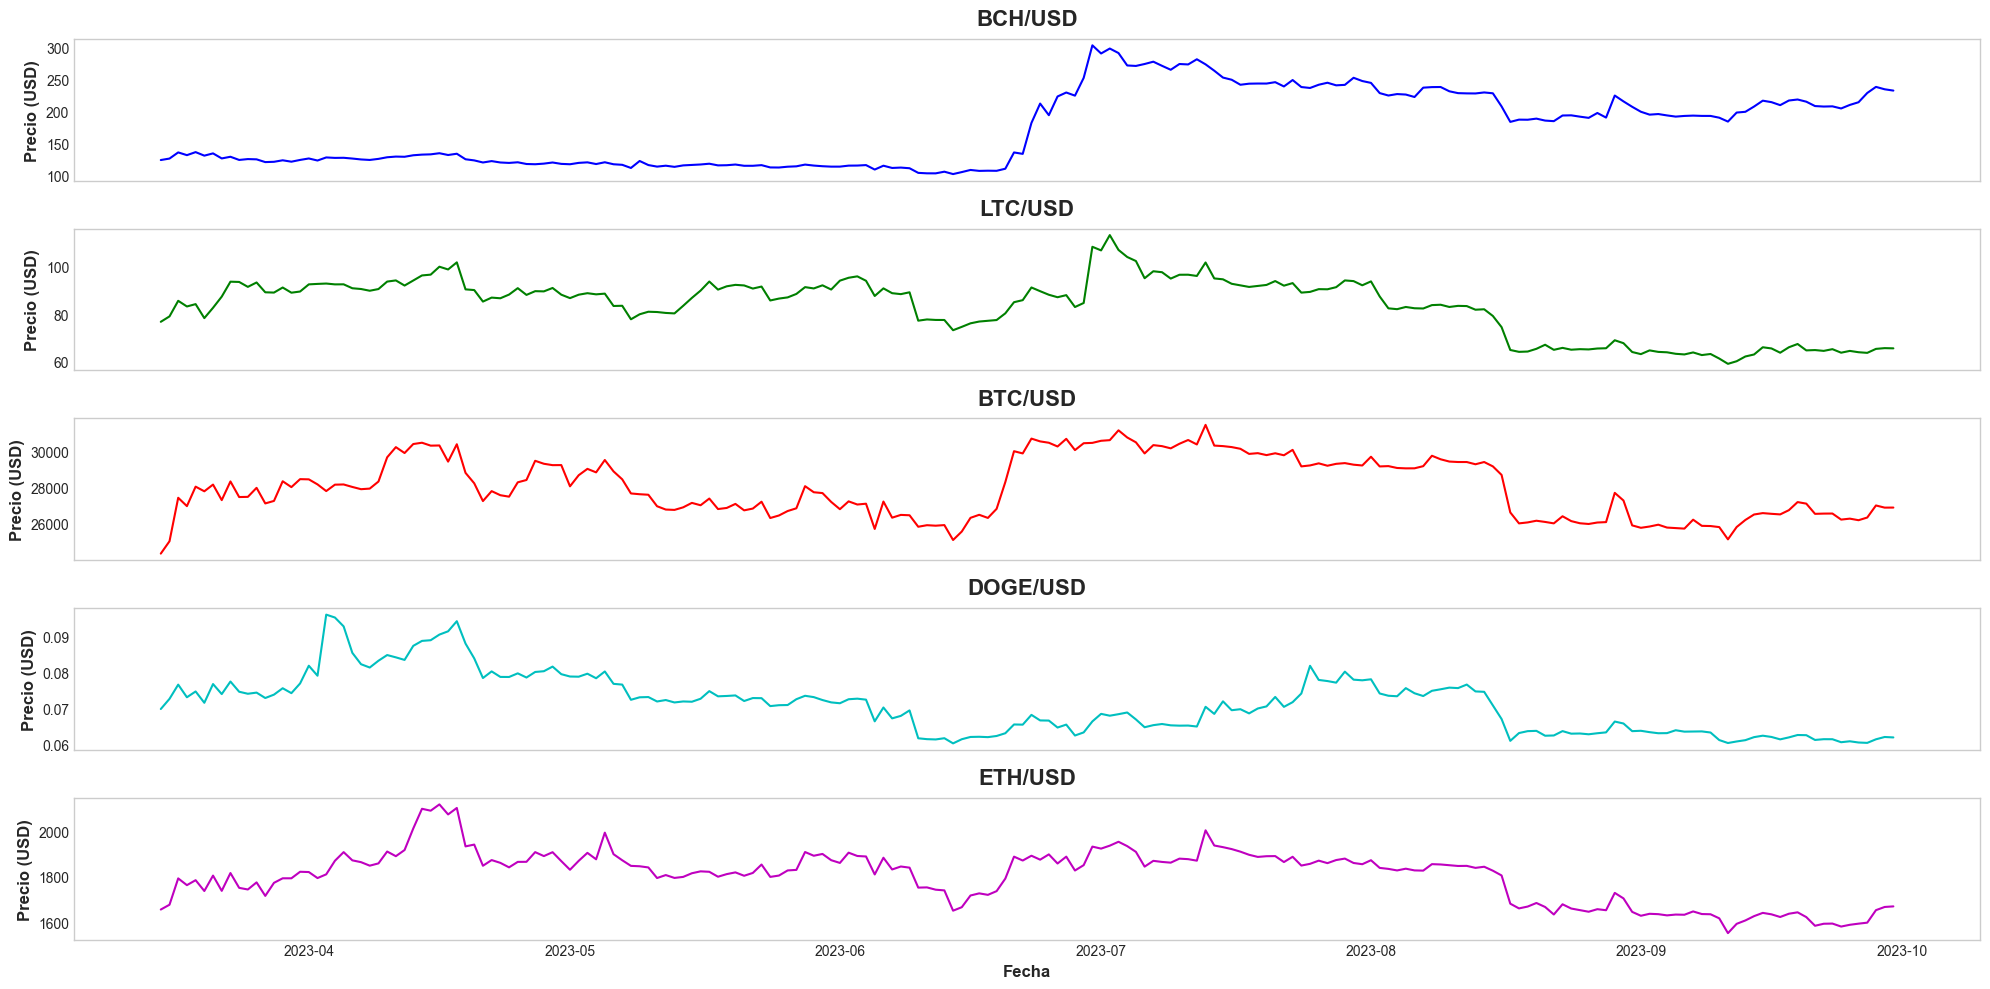

In [3]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, axs = plt.subplots(len(cryptos_df), 1, figsize=(20, 10), sharex=True)

for i, symbol in enumerate(cryptos_df):
    y_vals = cryptos_df[symbol]["close"].to_numpy()
    axs[i].set_title(symbol)
    axs[i].plot(timestamp, y_vals, color=colors[i])
    axs[i].legend()
    axs[i].set_ylabel("Precio (USD)")
    axs[i].grid()

plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

Se va a trabajar primero con una serie de tiempo

In [4]:
from tqdm import tqdm_notebook
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        endog - the observed variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

def normaliza(x, estimador = np.mean):
    # El argumento es de la clase pandas.Series
    parametro = estimador(x)
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1

    aux = (x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR))
    x[aux] = parametro
    return x

def fast_analysis(input_data, resample='W', lag=0):
    data = input_data.copy()
    out = normaliza(data, estimador=np.median)
    out = out.resample(resample).sum()
    if lag > 0: test = out.diff(lag)[lag:]
    else: test = out
    ad_fuller_result = adfuller(test)
    print('Stationary')
    print(f'\tlags: {lag}')
    print(f'\tADF Statistic: {round(ad_fuller_result[0], 6)}, p-value: {round(ad_fuller_result[1], 6)}')
    return out

In [5]:
import matplotlib.gridspec as gridspec
def plot_info(dataset, lag = 0):
    gs = gridspec.GridSpec(3, 2)
    ax1 = plt.subplot(gs[0, :]) # row 0, col 0
    ax2 = plt.subplot(gs[1, :]) # row 0, col 1
    ax3 = plt.subplot(gs[2, 0]) # row 1, span all columns
    ax4 = plt.subplot(gs[2, 1]) # row 1, span all columns

    print(f'Cantidad de lag: {lag}')
    ax1.plot(dataset)
    ax1.title.set_text('Importe')
    if lag > 0:
        dataset = dataset.diff(lag)[lag:]
    result = seasonal_decompose(dataset)
    ax2.plot(result.seasonal)
    ax2.title.set_text('Seasonality')
    plot_acf( dataset, ax=ax3)
    plot_pacf(dataset, ax=ax4)

    plt.show()

In [6]:
df = cryptos_df["BCH/USD"]
df.index = pd.to_datetime(cryptos_df["BCH/USD"]["timestamp"], unit="ms")
df["Precio"] = df["close"]
df = df["Precio"]
df.head()

timestamp
2023-03-15    123.65
2023-03-16    125.96
2023-03-17    135.63
2023-03-18    131.32
2023-03-19    136.08
Name: Precio, dtype: float64

Stationary
	lags: 1
	ADF Statistic: -3.569332, p-value: 0.006375
Stationary
	lags: 0
	ADF Statistic: -5.920181, p-value: 0.0
Cantidad de lag: 0


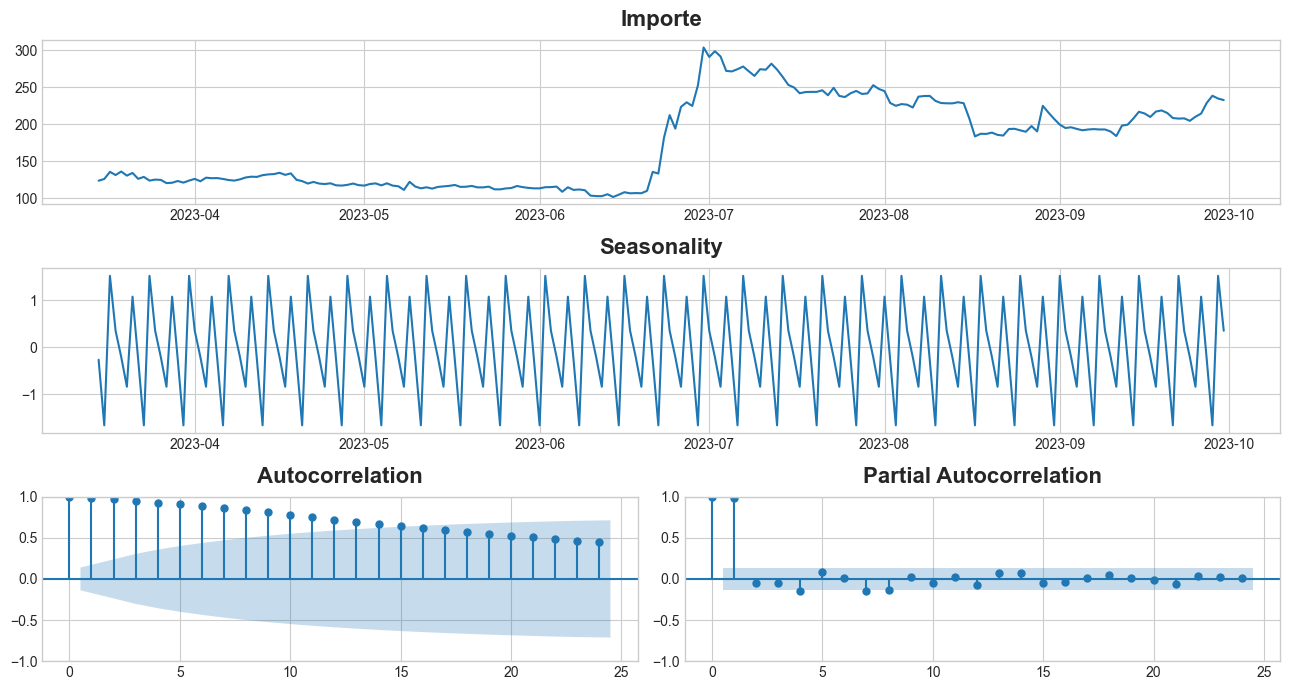

In [7]:
df_post = fast_analysis(df, lag=1, resample='d')
df_desc = seasonal_decompose(df_post).seasonal
fast_analysis(df_desc, lag=0)
plot_info(df_post, lag=0)


In [8]:
from itertools import product

p = range(2, 4, 1)
d = 0
q = range(2, 4, 1)
P = range(2, 4, 1)
D = 0
Q = range(2, 4, 1)
s = 52
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [9]:
print(len(parameters_list))
result_df = optimize_SARIMA(df, parameters_list, d, D, s)
result_df.head()

16


  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\Germain\anaconda3\envs\Acatlan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Germain\anaconda3\envs\Acatlan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Germain\anaconda3\envs\Acatlan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Germain\anaconda3\envs\Acatlan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Germain\anaconda3\envs\Acatlan\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 2, 2)",1443.458496
1,"(3, 3, 3, 2)",1444.568010
2,"(3, 3, 2, 3)",1444.579350
3,"(3, 3, 3, 3)",1446.494701
4,"(2, 3, 2, 2)",1454.688123


c:\Users\Germain\anaconda3\envs\Acatlan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Germain\anaconda3\envs\Acatlan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Germain\anaconda3\envs\Acatlan\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


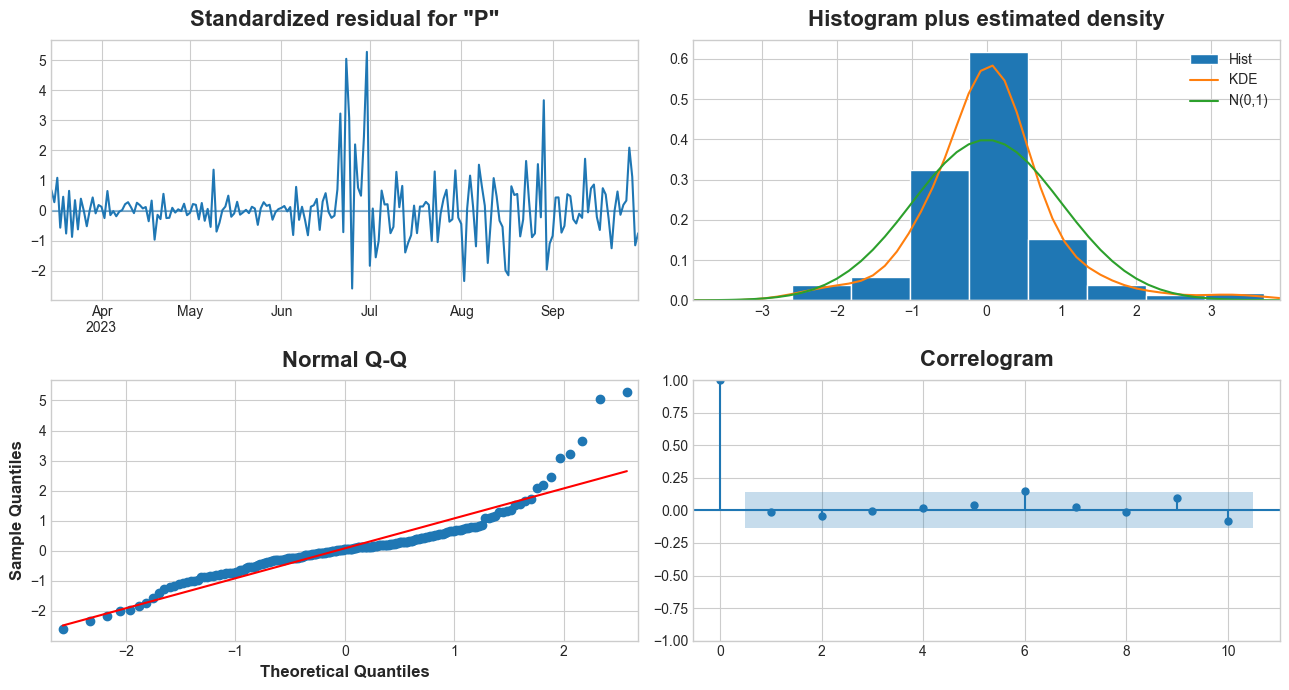

In [10]:
model = SARIMAX(df,
    order=(3, d, 3), seasonal_order=(2, D, 2, s),
    simple_differencing=False).fit(disp=False)
model.plot_diagnostics();

In [11]:
import plotly.graph_objects as go
# Para 6 * 2 = 8 semanas, aproximadamente dos meses
pred = model.get_forecast(52)
pred = pred.predicted_mean
datos = df
fig = go.Figure([
        go.Scatter(x = datos.index, y = datos.values, name='Real'),
        go.Scatter(x = pred.index, y = pred.values, name='Pronóstico')
    ])
fig.update_layout(xaxis_title="Fecha", yaxis_title="Importe", title='Pronostico')
fig.show()

In [12]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                  Precio   No. Observations:                  200
Model:             SARIMAX(3, 0, 3)x(2, 0, [1, 2], 52)   Log Likelihood                -710.729
Date:                                 Fri, 29 Sep 2023   AIC                           1443.458
Time:                                         21:25:59   BIC                           1479.740
Sample:                                     03-15-2023   HQIC                          1458.141
                                          - 09-30-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8963      0.110      8.141      0.000       0.681       1